In [1]:
!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 846.9/846.9 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 11.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.8/121.8 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.6/801.6 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.5/193.5 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.8/279.8 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 k

For this model I've decided to use the actual load instead of the predicted load. One possibility is to use both series, but have actual load as a past covariate and predicted load as a future covariate.

In [2]:
from darts import TimeSeries
import matplotlib.pyplot as plt
import pandas as pd


def load_csv_day_ahead_prices(year):
  region = 3

  df = pd.read_csv(f'dap-se{region}-{year}.csv')
  df.index = pd.to_datetime(
    df['MTU (CET/CEST)'].str.split(' - ').str[0],
    format='%d.%m.%Y %H:%M'
  )
  df.drop(
    columns=['MTU (CET/CEST)', f'BZN|SE{region}', 'Currency'],
    inplace=True
  )

  return df

def day_ahead_prices(start=2015, end=2023):
  region = 3

  df = pd.concat([load_csv_day_ahead_prices(year) for year in range(start, end + 1)])
  df = df.ffill()
  df = df[~df.index.duplicated(keep='first')]

  return df


def load_csv_total_load_forecast(year):
  region = 3

  df = pd.read_csv(f'tl-se{region}-{year}.csv')
  df.index = pd.to_datetime(
    df['Time (CET/CEST)'].str.split(' - ').str[0],
    format='%d.%m.%Y %H:%M'
  )
  df.drop(
    columns=['Time (CET/CEST)', f'Day-ahead Total Load Forecast [MW] - BZN|SE{region}'],
    inplace=True
  )
  df.rename(
    columns={ f'Actual Total Load [MW] - BZN|SE{region}': 'Actual Total Load [MW]' },
    inplace=True
  )

  return df

def total_load_forecast(start=2015, end=2023):
  region = 3

  df = pd.concat([load_csv_total_load_forecast(year) for year in range(start, end + 1)])
  df = df.ffill()
  df = df[~df.index.duplicated(keep='first')]

  return df


def load_smhi(filename): # start = 2015, end = 2023
  df = pd.read_csv(filename, delimiter=';', quoting=3)
  df.index = pd.to_datetime(
    df['Datum'] + " " + df['Tid (UTC)'],
    format='%Y-%m-%d %H:%M:%S'
  )
  df.drop(
    columns=['Datum', 'Tid (UTC)', 'Kvalitet'],
    inplace=True
  )
  df = df.resample('1H').asfreq()
  df = df.ffill()
  df = df[~df.index.duplicated(keep='first')]
  return df

# All data

<Axes: xlabel='MTU (CET/CEST)'>

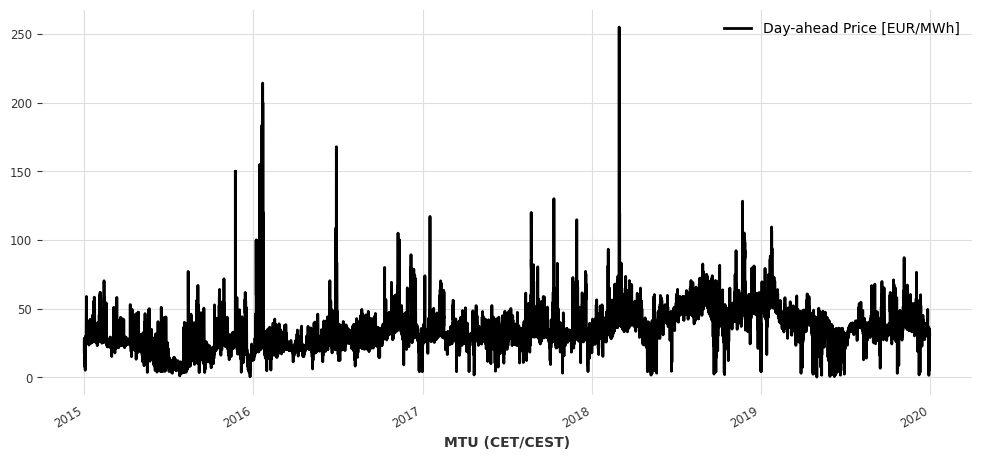

In [3]:
end_year = 2019

df = day_ahead_prices(start=2015, end=end_year)
series = TimeSeries.from_dataframe(df)

plt.figure(figsize=(12,5))
series.plot()

# Processing

In [4]:
import numpy as np

class MLogScaler:
  def __init__(self, c = 1 / 3):
    self.c = c

  def fit(self, X):
    return self

  def transform(self, X):
    return np.sign(X) * (np.log(1 / self.c + np.abs(X)) + np.log(self.c))

  def inverse_transform(self, X):
    return np.sign(X) * (np.exp(np.abs(X) - np.log(self.c)) - 1 / self.c)

<Axes: xlabel='MTU (CET/CEST)'>

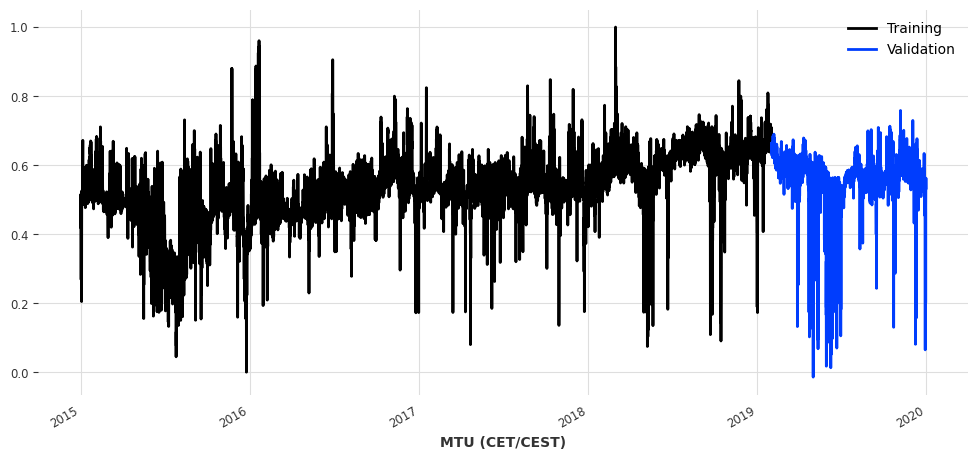

In [5]:
from darts.dataprocessing.transformers import Scaler

cutoff = pd.Timestamp(f'{end_year}-02-01')
train, val = series.split_before(cutoff)

mlog = Scaler(scaler=MLogScaler())
train_mlog = mlog.fit_transform(train)
val_mlog = mlog.transform(val)
series_mlog = mlog.transform(series)

compress = Scaler()
train_transformed = compress.fit_transform(train_mlog)
val_transformed = compress.transform(val_mlog)
series_transformed = compress.transform(series_mlog)

plt.figure(figsize=(12, 5))
train_transformed.plot(label='Training')
val_transformed.plot(label='Validation')

In [14]:
len(train_transformed)

35808

# Covariates

## Actual Load

<Axes: xlabel='Time (CET/CEST)'>

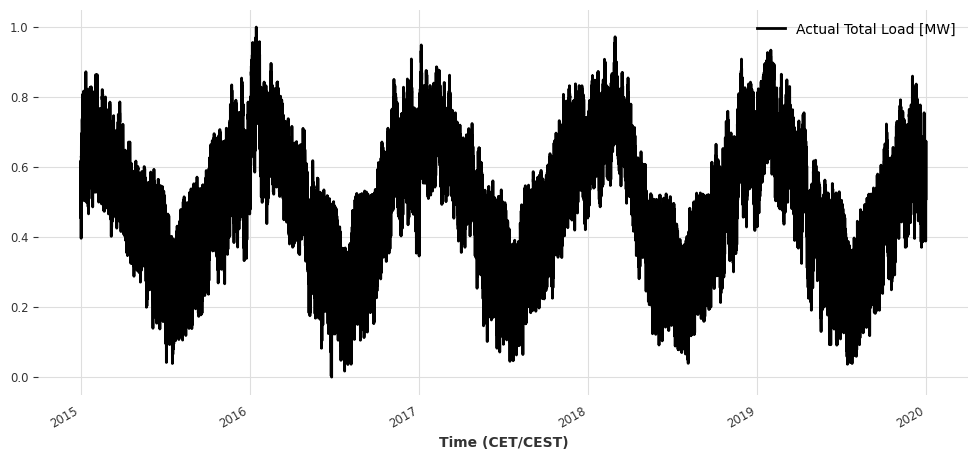

In [6]:
predicted_load_series = TimeSeries.from_dataframe(total_load_forecast(start=2015, end=end_year))

predicted_load_series = Scaler().fit_transform(predicted_load_series.map(lambda ts, x: np.log(x)))

plt.figure(figsize=(12, 5))
predicted_load_series.plot()

## Date-Time Features

(16430.0, 16477.0)

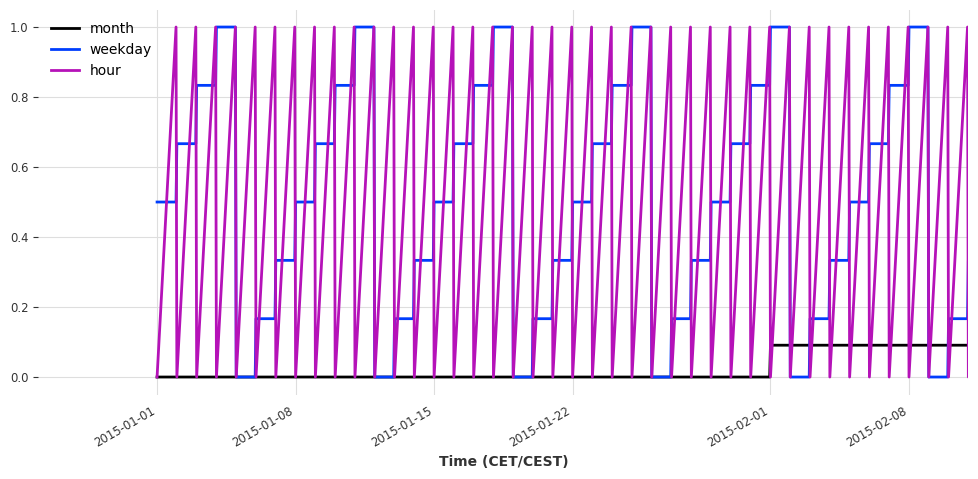

In [7]:
from darts.utils.timeseries_generation import datetime_attribute_timeseries

month_series = datetime_attribute_timeseries(
  predicted_load_series,
  attribute="month"
)
month_series = Scaler().fit_transform(month_series)

weekday_series = datetime_attribute_timeseries(
  month_series,
  attribute="weekday"
)
weekday_series = Scaler().fit_transform(weekday_series)

hour_series = datetime_attribute_timeseries(
  weekday_series,
  attribute="hour"
)
hour_series = Scaler().fit_transform(hour_series)

datetime_series = month_series.stack(weekday_series).stack(hour_series)

plt.figure(figsize=(12, 5))
datetime_series.plot()
plt.xlim(
  left=datetime_series.start_time() - pd.DateOffset(days=6),
  right=datetime_series.start_time() + pd.DateOffset(months=1, days=10)
)

# Weather Conditions

(16436.0, 16495.0)

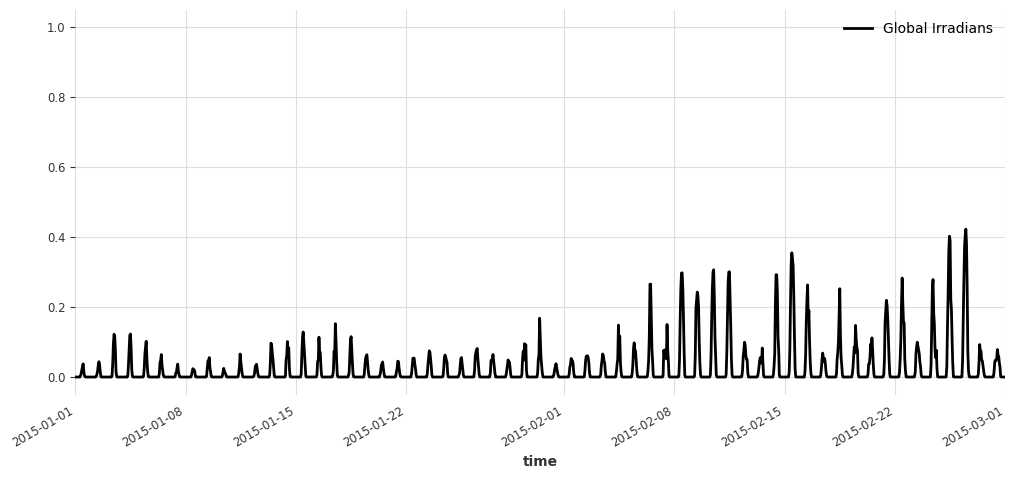

In [8]:
solar_df = load_smhi('smhi-solar-radiation-stockholmsol.csv')

solar_series = TimeSeries.from_dataframe(solar_df)
solar_series = solar_series.drop_after(pd.Timestamp(f'{end_year + 1}-01-01'))
solar_series = Scaler().fit_transform(solar_series)

plt.figure(figsize=(12, 5))
solar_series.plot()
plt.xlim(left=solar_series.start_time(), right=solar_series.start_time() + pd.DateOffset(months=2))

(16436.0, 16495.0)

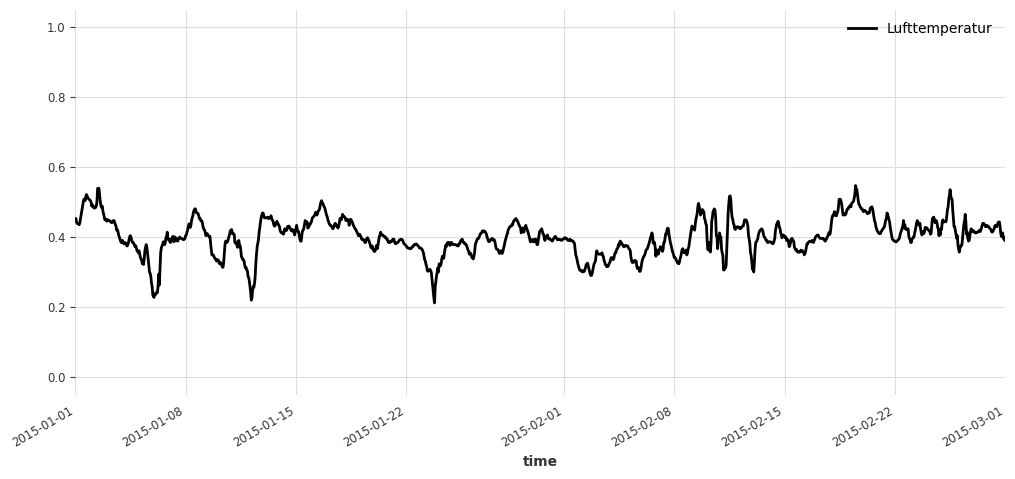

In [9]:
temperature_df = load_smhi('smhi-temperature-bma.csv')

temperature_series = TimeSeries.from_dataframe(temperature_df)
temperature_series = temperature_series.drop_after(pd.Timestamp(f'{end_year + 1}-01-01'))
temperature_series = Scaler().fit_transform(temperature_series)

plt.figure(figsize=(12, 5))
temperature_series.plot()
plt.xlim(left=temperature_series.start_time(), right=temperature_series.start_time() + pd.DateOffset(months=2))

(16436.0, 16495.0)

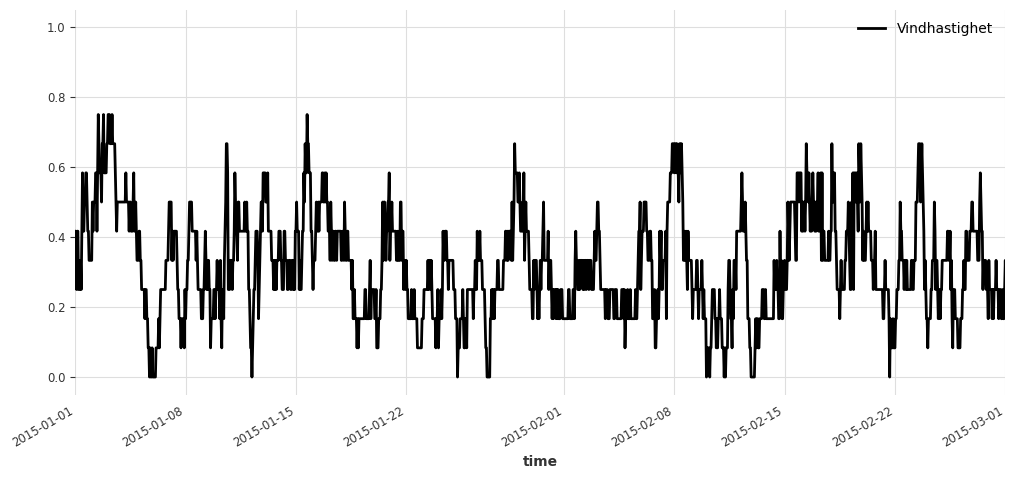

In [10]:
windspeed_df = load_smhi('smhi-windspeed-bma.csv').drop(columns=['Vindriktning', 'Kvalitet.1'])

windspeed_series = TimeSeries.from_dataframe(windspeed_df)
windspeed_series = windspeed_series.drop_after(pd.Timestamp(f'{end_year + 1}-01-01'))
windspeed_series = Scaler().fit_transform(windspeed_series)

plt.figure(figsize=(12, 5))
windspeed_series.plot()
plt.xlim(left=windspeed_series.start_time(), right=windspeed_series.start_time() + pd.DateOffset(months=2))

In [11]:
weather_series = solar_series.stack(temperature_series).stack(windspeed_series)
covariates = predicted_load_series.stack(datetime_series).stack(weather_series)

# Model Creation

These hyperparameters are untested!

In [19]:
from darts.models import NBEATSModel
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    min_delta=0.0001,
    mode='min',
)

nbeats_model = NBEATSModel(
  n_epochs=100,

  input_chunk_length=48,
  output_chunk_length=24,
  num_stacks=2,
  num_blocks=1,
  num_layers=4,
  layers_width=256,

  batch_size=128,
  dropout=0.2,
  pl_trainer_kwargs={ 'callbacks': [early_stop] },

  optimizer_kwargs={ 'lr': 1e-2 },
  save_checkpoints=True,
  log_tensorboard=True,
  model_name='NBEATS_DayAheadPrices',

  force_reset=True,
  random_state=42
)

nbeats_model.fit(
  train_transformed,
  past_covariates=covariates,
  val_series=val_transformed,
  val_past_covariates=covariates,
  verbose=True
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 603 K 
---------------------------------------------------
600 K     Trainable params
3.6 K     Non-trainable params
603 K     Total params
2.416     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=2, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.2, activation=ReLU, n_epochs=100, input_chunk_length=48, output_chunk_length=24, batch_size=128, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7e7e69149060>]}, optimizer_kwargs={'lr': 0.01}, save_checkpoints=True, log_tensorboard=True, model_name=NBEATS_DayAheadPrices, force_reset=True, random_state=42)

# Evaluation

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

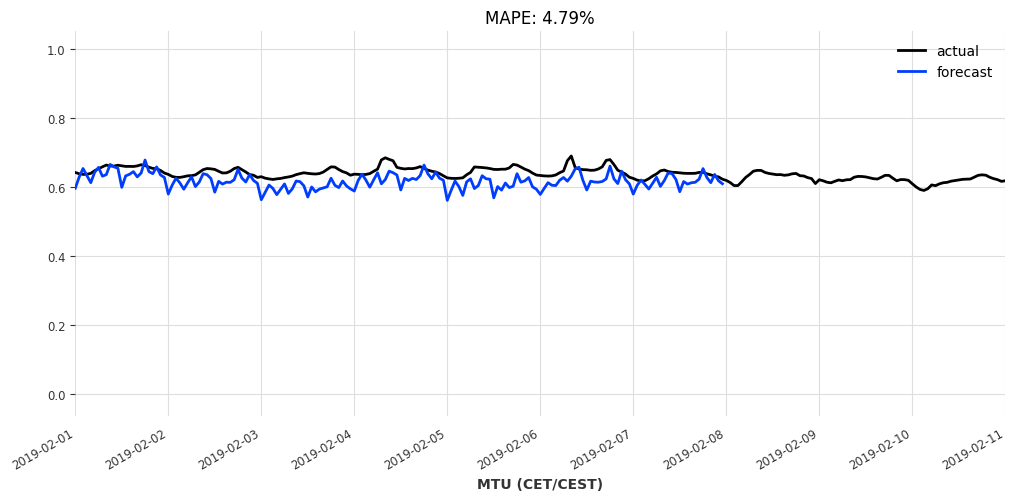

In [20]:
from darts.metrics import mape

def eval_model(model):
  pred_series = model.predict(n=168, past_covariates=covariates)
  plt.figure(figsize=(12, 5))
  series_transformed.plot(label="actual")
  pred_series.plot(label="forecast")
  plt.xlim(
    left=pd.Timestamp(cutoff),
    right=pd.Timestamp(cutoff) + pd.DateOffset(days=10)
  )
  plt.title("MAPE: {:.2f}%".format(mape(pred_series, val_transformed)))
  plt.legend()

eval_model(nbeats_model)